# Moment map tutorial for MIGHTEE-HI data

***
By Sambatriniaina H. A. Rajohnson,

Ph.D student at the University of Cape Town, South Africa.

with the helps of Wanga Mulaudzi and Marcin Glowacki.

May 11, 2020.
***

Welcome to the image analysis tutorial for MeerKAT spectral line data. After identifying HI sources in the cube and storing them into a file, we can start looking at the moment maps for each detection.

Moment maps are generated by taking various integrals over the velocity axis. By studying the emission channel by channel, the moment zero map is also referred to as the total HI map describing the overall gas distribution. It is proportional to the HI column density and represents the HI surface density. Moment one is representing the intensity-weighted velocity ﬁeld or the gas motion, and moment two the velocity dispersion.
![](.\Picture_1.png)

This notebook will help you to generate moment 0 and moment 1 maps of the detections in your cube.

***
## 1- Inputs

In [1]:
detections_list = '/users/aycha/MIGHTEE/notebooks/all_detections_1380_1420.dat' 
                     #Please input the path to your detection file list in an ASCII table format (e.g xxx.dat) with columns RA DEC FREQ
                     #Where ra, dec = 02h17m40.0s, 04d33m40.0s or in decimal coordinates 33.44444, 04.55555
                     #frequency in GHz. 
path_to_cube='/idia/projects/mightee/mightee-hi/XMMLSS12/12/XMMLSS12_12.CORR.1380.ms.contsub.dirty.w128.image.fits'      
                     #Please input the path to the FITS cube

#Extraction parameters

subcube_width=2 #in arcmin
subcube_width_in_text='2arcmin'
# However, we may encounter detections with bigger size, so you can select their index numbers:
index = [2]# for example in my detection, the detection with index 2 is bigger and should have a width of 4 arcminutes.
width_new=4
width_new_in_text='4arcmin'
velocity_convention='radio' #you can also change to 'optical'
half_freq_width=1e-3        #it is better to select a small frequency range for making moment maps, with this a 2MHz subcube will be extracted

#Beam convolution parameters

circular_beam_axis = 20 # 20'' x 20''

#Moment maps parameters
sigma=3                #Masking
mean_profile_width=300 #km/s, needed for moment 1 map
dirName = 'Moment_maps_1380_w128_sorted_by_freq' #Path of the Directory for moment maps to be created

## 2-Modules and initialization

In [2]:
import spectral_cube
from spectral_cube import SpectralCube
from spectral_cube.cube_utils import Beam
from astropy.io import ascii
from astropy.io import fits
import Distance_package #a python file for calculating Distance in a cosmological manner
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.cosmology import WMAP7
from astropy.coordinates import SkyCoord
%matplotlib inline

pl.rc('axes',titlesize='large')
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'serif','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family'] = 'serif'

## 3-Detection extraction and Noise estimation

Subcubes containing all the detections will be extracted in the main cube. They will be defined as the signal cubes, having a certain width w in arcminutes (depending on the detection size). Since the noise is varying locally in the cube, it is needed to know the noise next in the region right to the signal cube but not containing any emission. This will be defined as noise cube, a cube of the exact same size as the signal cube which will be used to estimate the local rms for each detection. 

![](.\Picture_2.png)

In [3]:
def get_subcube_and_noisecube(cube, ra, dec, freq, velocity_convention='radio', width_in_arcmin = 0.5*u.arcmin, width='30arcsec', dfreq=0.0005):
    '''
    RA, DEC, FREQ will be taken from the detections_table
    freq in GHz.
    width of 30arcsec 
    frequency width of dfreq of 500KHz
    This are the default values but can be changed when calling the function
    '''
    
    freq_lower = '%.5fGHz' % (freq-dfreq) #frequency ranges
    freq_upper = '%.5fGHz' % (freq+dfreq)
    crtf_str = 'centerbox[['+ra+','+dec+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    #extracting a squared cube with a certain width at the ra and dec position at a specific frequency range
    #crtf_str = 'circle[['+ra+','+dec+'], '+width+'], coord=fk5, range=['+freq_lower+', '+freq_upper+']]' #for a circle
    # fk5 is just another frame like icrs
    
    #RA and DEC into degree if not yet decimal
    coord = SkyCoord(ra, dec, frame='fk5')
    ra_deg = coord.ra.deg + width_in_arcmin.to(u.deg).value
    dec_deg = coord.dec.deg # same declination

    noise_crtf = 'centerbox[['+str(ra_deg)+','+str(dec_deg)+'], ['+width+','+width+']], coord=fk5, range=['+freq_lower+', '+freq_upper+']]'
    # Noise cube extraction

    target_subcube = cube.subcube_from_crtfregion(crtf_str) 
    #generating the new signal cube from the crtf region, spectral axis = frequency
    noise_subcube = cube.subcube_from_crtfregion(noise_crtf) 
    #generating the corresponding noise cube from the crtf region, spectral axis = frequency
    freqs = target_subcube.spectral_axis #The frequency units is in Hertz
    
    #Converting the cube spectral axis into velocity km/s in radio or optical convention
    #the signal cubes will be chosen depending on the observer
    vel_subcube = target_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    noise_velsubcube = noise_subcube.with_spectral_unit(u.km / u.s, velocity_convention=velocity_convention, rest_value=1.42040575e9 * u.Hz)
    
    #Storing the velocity axis value separately from the cube so that we can use later
    vel = vel_subcube.spectral_axis
    
    #flux density values in Jy/beam
    target_spectrum_sum = target_subcube.sum(axis=(1,2))/target_subcube.unit
    
    
    # The outputs will be:
    # the signal cube with spectral axis frequency
    # the signal cube with spectral axis velocity
    # the frequency axis
    # the velocity axis
    # the flux density
    # the noise cube with spectral axis velocity
    return target_subcube, vel_subcube, freqs, vel, target_spectrum_sum,noise_velsubcube

## 4- Moment maps

Steps for making moment maps:
* **Convolve your cube into a common restoring beam:** the bigger the restored beam is, the more sensitive to faint emission we will be. For that, we will convolve the signal cubes into 3 different beams for spatial smoothing:
    * a common restoring beam (different for each detection),
    * a beam 50% bigger than the common restoring beam. Since this one will be different for each detection, we will need to create a common beam for all the detection. The bigger the better.
    * a circular common beam for all the detections: bmaj=bmin, bpa = 0 deg. Let's say for example $20'' \times~20''$ as default, but you can change it.
* **Convolve your noise cubes into the same restoring beam**
* **Measure mean noise in the noise cubes**
* **Calculate the scale bar for each detection**: in the moment map, we need to know the scale of the HI emission. The map is in pixels, and we know that for our imaging for example 1 pixel = 2 arcsec, so by knowing the distance of the galaxy by assuming a small angle, we will know the size of 10 pixels in parsecs.

In [4]:
def beam_convolution_and_mean_rms(cube,noise_cube,beam,detections_list):
    '''
    Cube to be convolved
    Common beam to convolve
    Detections list
    '''
    convolved_cube = []
    convolved_noise_cube = []
    mean_rms = []
    # Loop through each detections
    for i in range(len(detections_list)):
        
        convolved_cube.append(cube[i].convolve_to(beam))
        convolved_noise_cube.append(noise_cube[i].convolve_to(beam))
        x = convolved_noise_cube[i].std(axis=(1,2))/convolved_noise_cube[i].unit #getting the std for each channel
        mean_rms.append(np.mean(x))
        
    return convolved_cube, convolved_noise_cube, mean_rms

#Knowing the scale bar
#Redshift calculations
def calc_z(nu):
    '''
    nu is the observed frequency in GHz
    '''
    nu_0 = 1.42040575 # Rest frequency
    return (nu_0 - nu)/nu

#Scale bar calculation: conversion from arcsec to pc:
def angle_to_pc(x_arcsec,distance_Mpc):
    D = x_arcsec*(u.arcsec.to(u.rad))*distance_Mpc
    return D.to(u.kpc)

In [5]:
#Making a scale bar for the data

import matplotlib.offsetbox
from matplotlib.lines import Line2D

class AnchoredHScaleBar(matplotlib.offsetbox.AnchoredOffsetbox):
    """ size: length of bar in data units
        extent : height of bar ends in axes units """
    def __init__(self, size=1, extent = 0.03, label="", loc=2, ax=None,
                 pad=0.4, borderpad=0.5, ppad = 0, sep=2, prop=None, 
                 frameon=True, **kwargs):
        if not ax:
            ax = plt.gca()
        trans = ax.get_xaxis_transform()
        size_bar = matplotlib.offsetbox.AuxTransformBox(trans)
        line = Line2D([0,size],[0,0], **kwargs)
        vline1 = Line2D([0,0],[-extent/2.,extent/2.], **kwargs)
        vline2 = Line2D([size,size],[-extent/2.,extent/2.], **kwargs)
        size_bar.add_artist(line)
        size_bar.add_artist(vline1)
        size_bar.add_artist(vline2)
        txt = matplotlib.offsetbox.TextArea(label, minimumdescent=False)
        self.vpac = matplotlib.offsetbox.VPacker(children=[size_bar,txt],  
                                 align="center", pad=ppad, sep=sep) 
        matplotlib.offsetbox.AnchoredOffsetbox.__init__(self, loc, pad=pad, 
                 borderpad=borderpad, child=self.vpac, prop=prop, frameon=frameon)

In [6]:
def moment_0(cube,rms,beam,scale,sigma=3,title='moment 0'):
    #Masking the cube
    masked_cube = cube.with_mask(cube > sigma*rms*cube.unit)
    
    #Moment 0 of the masked cube
    moment0 = masked_cube.moment(order=0)
    
    # Clip the mom0 map
    clip1_mom0 = np.clip(moment0.array, a_min=sigma*rms, a_max=1)
    
    #fig = pl.figure(figsize=(13, 10))
    #ax = fig.add_subplot(111, projection=moment0.wcs)
    
    ax.set_facecolor('xkcd:white')
    # Contour levels
    cs = ax.contourf(clip1_mom0,cmap="gist_heat_r") #contour filled
    ax.contour(cs,colors='k',linewidths=1)
    
    cbar = plt.colorbar(cs,pad=0)
    cbar.ax.set_ylabel(r'Integrated flux (Jy beam$^{-1}$ km s$^{-1}$)')

    # Add axes labels

    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.set_title(title,fontsize=25)
    #ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1, direction='in')
    #ax.tick_params(which='minor', length=3, width=2, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    #ax.invert_yaxis() #invert the declination
    
    #Add scale bar
    #scalebar = ScaleBar(1.09275693) # 1 pixel = 2 arcsec = 1.09275693 kpc
    #plt.gca().add_artist(scalebar)
    ob = AnchoredHScaleBar(size=10, label=str(np.round(scale)), loc=1, frameon=False,
                       pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    
    #Beam values
    #Plotting the restored PSF:
    #Non convolved:12"x10" 39.5 deg, common beam: , 50% beam
    from matplotlib.patches import Ellipse

    ellipse = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
    ax.add_patch(ellipse)
    return masked_cube

In [7]:
def moment_1(cube,rms,beam,scale,vrange=300,sigma=3,title='moment 1'):
    
    vmin = cube.spectral_axis[-1].value #will change the color
    vmax = vmin+vrange
    a_min = vmin-1000
    a_max = vmax+1000
    
    #Masking the cube
    masked_cube = cube.with_mask(cube > sigma*rms*cube.unit)
    
    #Moment 0 of the masked cube
    moment1 = masked_cube.moment(order=1)
    
    #fig = pl.figure(figsize=(15, 10))
    #ax = fig.add_subplot(111, projection=moment1.wcs)
    
    # Clip the mom0 map
    clip1_mom1 = np.clip(moment1.array, a_min=a_min, a_max=a_max)
    im = ax.imshow(clip1_mom1, cmap='jet', vmin=vmin, vmax=vmax) #pixelized image
    
    ax.set_facecolor('xkcd:white')
    # Contour levels
    ax.contour(clip1_mom1, colors='k',linewidths=1)
    
    cbar = plt.colorbar(im,pad=0)
    cbar.ax.set_ylabel(r'Velocity (km s$^{-1}$)')

    # Add axes labels

    ax.set_xlabel("Right Ascension (J2000)", fontsize=20)
    ax.set_ylabel("Declination (J2000)", fontsize=20)
    ax.set_title(title,fontsize=25)
    #ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1, direction='in')
    #ax.tick_params(which='minor', length=3, width=2, direction='in')
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    #ax.invert_yaxis() #invert the declination
    
    #Add scale bar
    #scalebar = ScaleBar(1.09275693) # 1 pixel = 2 arcsec = 1.09275693 kpc
    #plt.gca().add_artist(scalebar)
    ob = AnchoredHScaleBar(size=10, label=str(np.round(scale)), loc=1, frameon=False,
                       pad=0.6,sep=4,color="k", linewidth=2) #10 pixels scale
    ax.add_artist(ob)
    
    
    #Beam values
    #Plotting the restored PSF:
    #Non convolved:12"x10" 39.5 deg, common beam: , 50% beam
    from matplotlib.patches import Ellipse

    ellipse = Ellipse(xy=(11, 11), width=beam.major.to(u.arcsec).value, height=beam.minor.to(u.arcsec).value, 
                        edgecolor='k', fc='None', lw=1,angle=-beam.pa.to(u.deg).value) #Anti-clockwise
    ax.add_patch(ellipse)

## 5-Let's run!

In [8]:
detections = ascii.read(detections_list)
cube = SpectralCube.read(path_to_cube)
pixel_size= cube.header['CDELT2']*3600


# Subcube and noise cubes extractions
tsum = [] #sum value of the flux
vel = [] # velocity
vel_subcube = [] #subcube with velocity axis
noise_velsubcube = []

for i in range(len(detections)):
    ra = detections[i]['ra'] #taking the RA column
    dec = detections[i]['dec'] #taking the DEC column
    freq = detections[i]['freq'] #taking the FREQ column
    if i in index:
        a, b, c, d, e, f = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = width_new*u.arcmin, width=width_new_in_text, dfreq=half_freq_width)
    else:
        a, b, c, d, e, f = get_subcube_and_noisecube(cube, ra, dec, freq,width_in_arcmin = subcube_width*u.arcmin, width=subcube_width_in_text, dfreq=half_freq_width)
    tsum.append(e)
    vel.append(d) 
    vel_subcube.append(b)
    noise_velsubcube.append(f)

#redshift into distance
z = []
for i in range(len(detections)):
    z.append(calc_z(detections[i]['freq']))
    
d = Distance_package.Distance(z=z,cosmology=WMAP7)

#scale bar for 10 pixels
scale = []
for i in range(len(detections)):
    scale.append(angle_to_pc(10*pixel_size,d[i])) #10 pixels scale
    
# BEAMS:
common_beam = cube[1:].beams.common_beam()
if common_beam.major.unit == u.arcsec:
    bmaj = common_beam.major
    bmin = common_beam.minor
else:
    bmaj = common_beam.major.value*3600*u.arcsec
    bmin = common_beam.minor.value*3600*u.arcsec
beam50 = Beam(major=1.5*bmaj, minor=1.5*bmin, pa=common_beam.pa.to(u.deg)) #50 percent bigger beam
circular_beam = Beam(major=circular_beam_axis*u.arcsec, minor=circular_beam_axis*u.arcsec, 
                   pa=0*u.deg)

#Convolution and rms:
vel_common, noise_common, mean_rms_common = beam_convolution_and_mean_rms(vel_subcube,noise_velsubcube,common_beam,detections)
vel_beam50, noise_beam50, mean_rms_beam50 = beam_convolution_and_mean_rms(vel_subcube,noise_velsubcube,beam50,detections)
vel_circular, noise_circular, mean_rms_circular = beam_convolution_and_mean_rms(vel_subcube,noise_velsubcube,circular_beam,detections)

/users/aycha/.local/lib/python3.7/site-packages/spectral_cube/masks.py:632: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return LazyMask(self._function, data=self._data[view],
/users/aycha/.local/lib/python3.7/site-packages/spectral_cube/masks.py:546: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return BooleanArrayMask(self._mask[view],
/users/aycha/.local/lib/python3.7/site-packages/spectral_cube/masks.py:550: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

Directory  Moment_maps_1380_w128_sorted_by_freq  Created 


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/aycha/.local/lib/python3.7/site-packages/spectral_cube/_moments.py:169: RuntimeWarning: invalid value encountered in true_divide
  np.nansum(data, axis=axis))
/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fonte

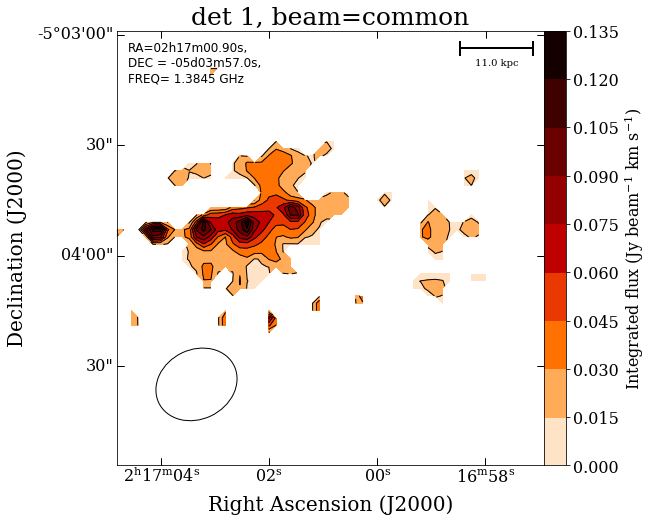

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


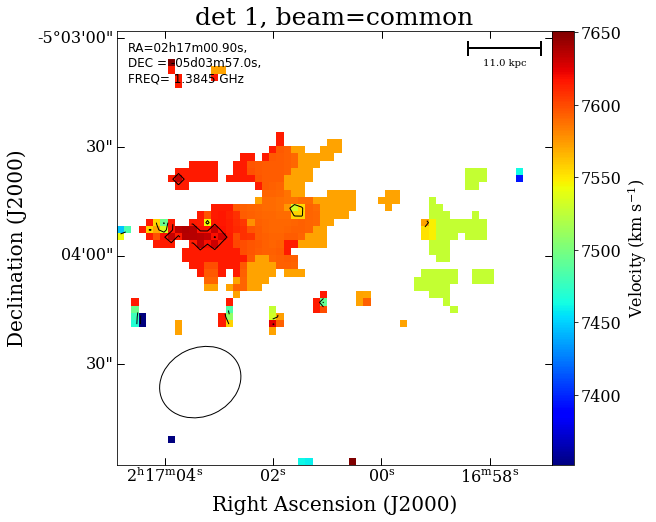

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


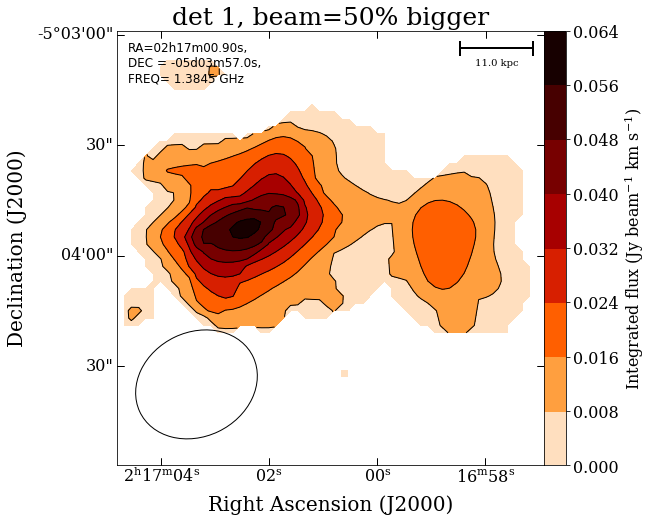

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


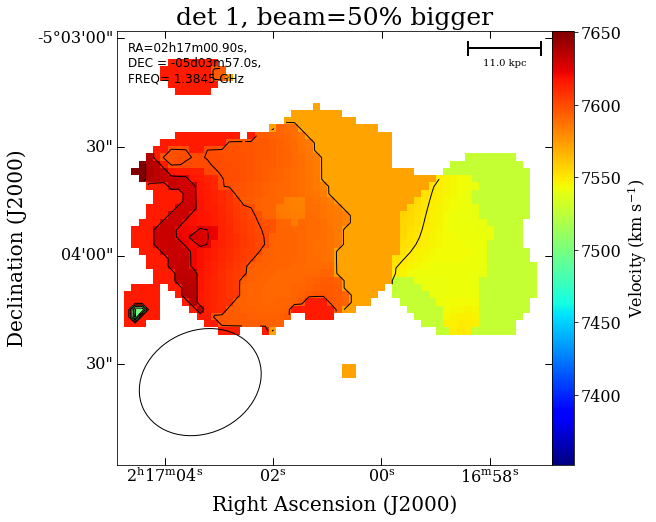

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


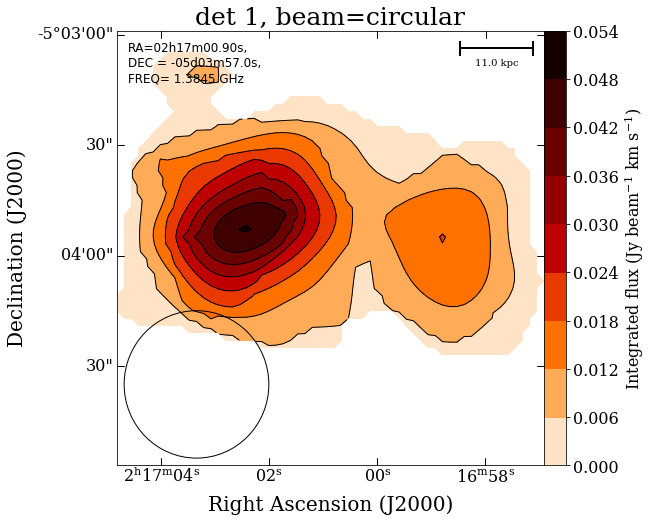

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


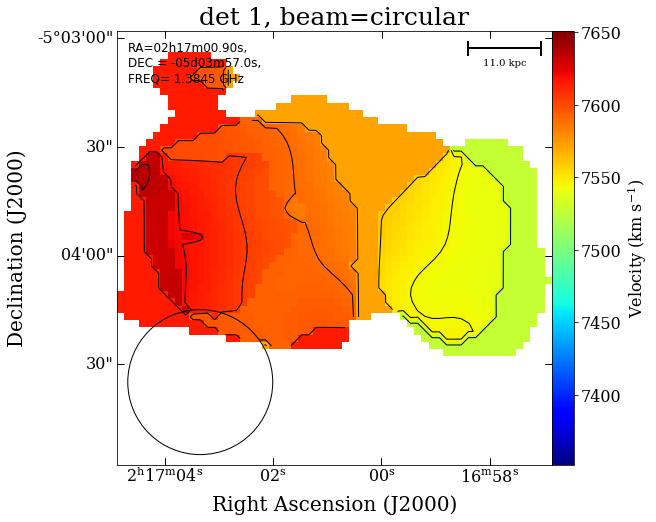

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


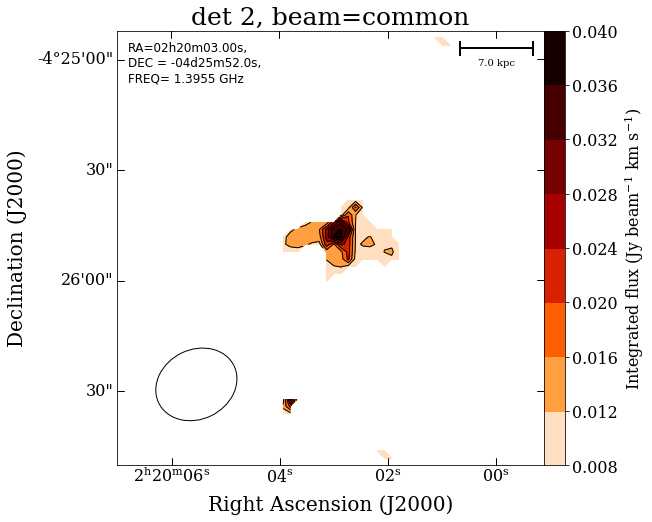

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


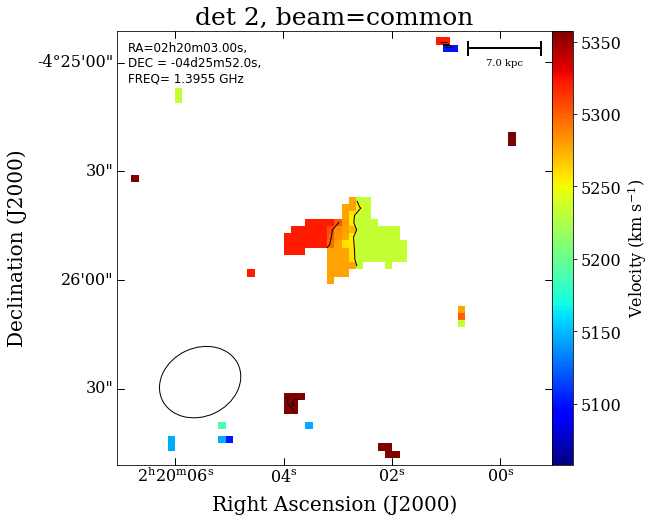

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


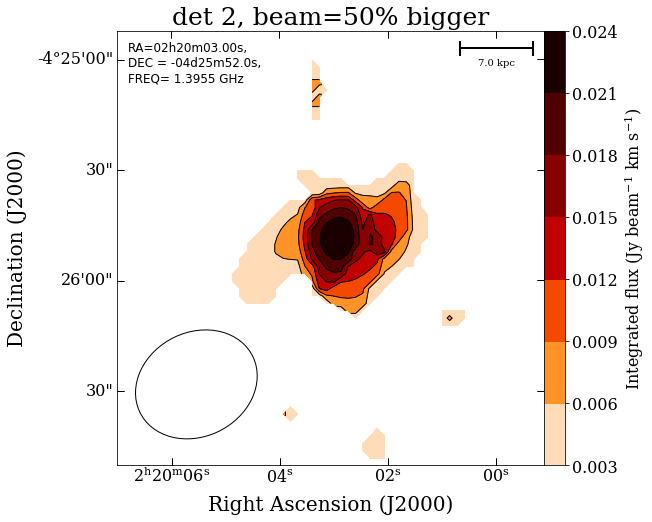

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


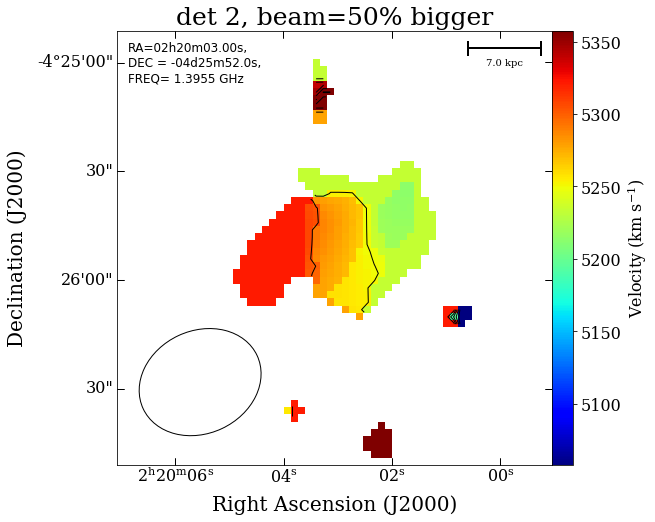

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


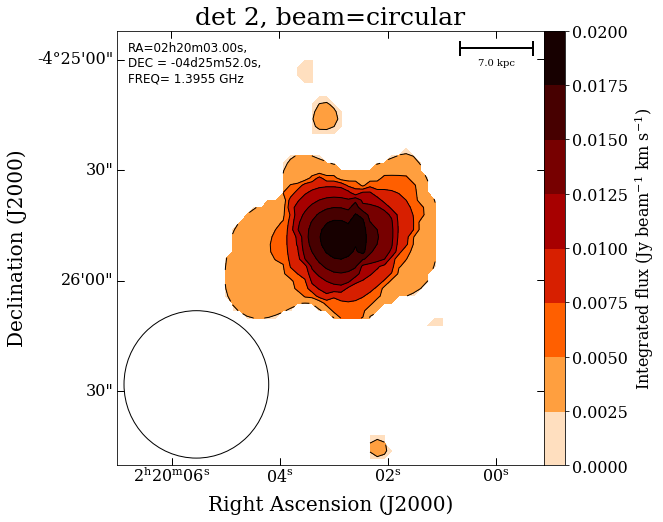

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


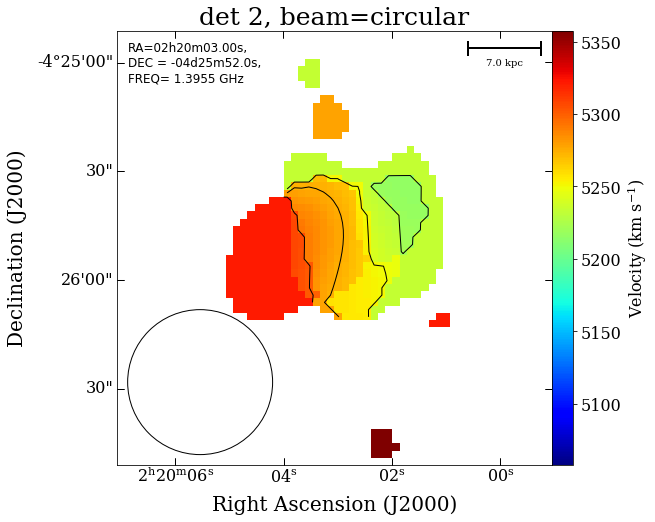

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


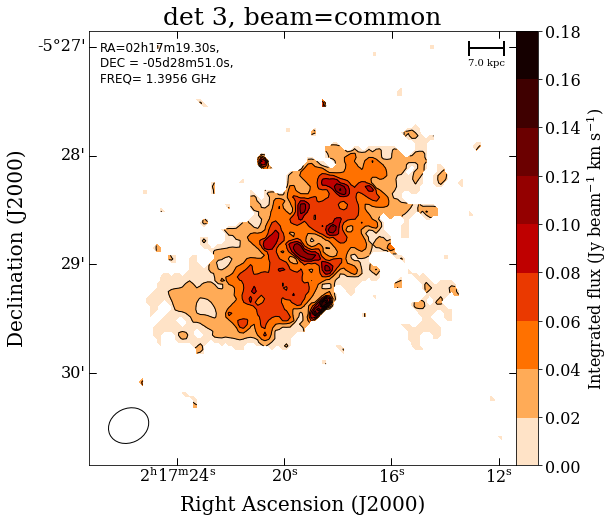

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


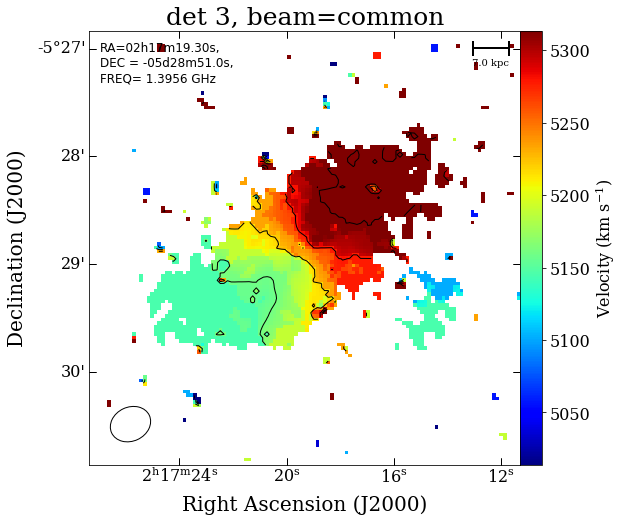

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


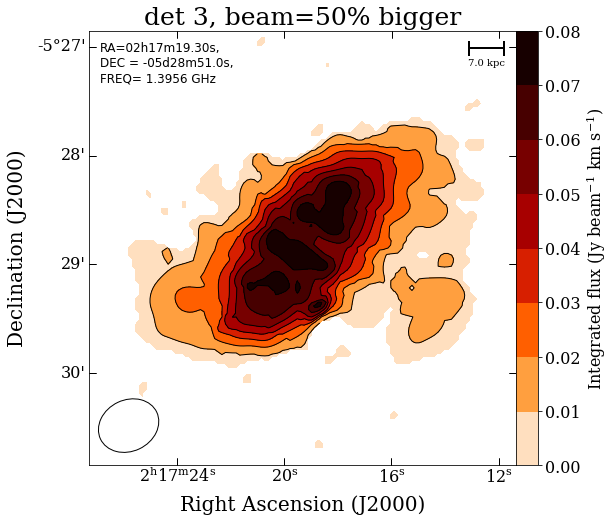

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


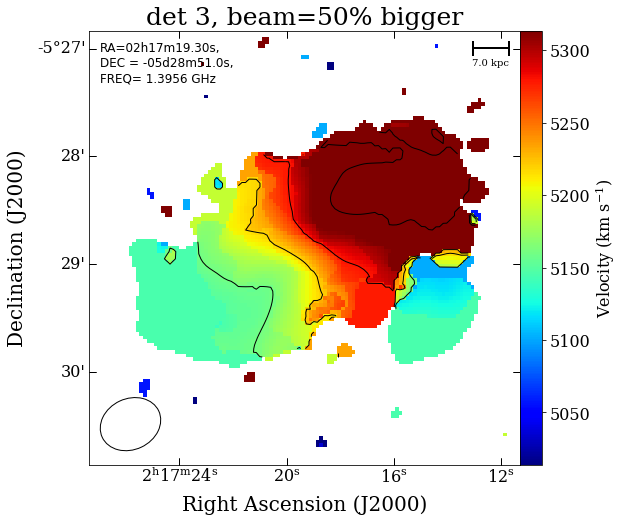

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


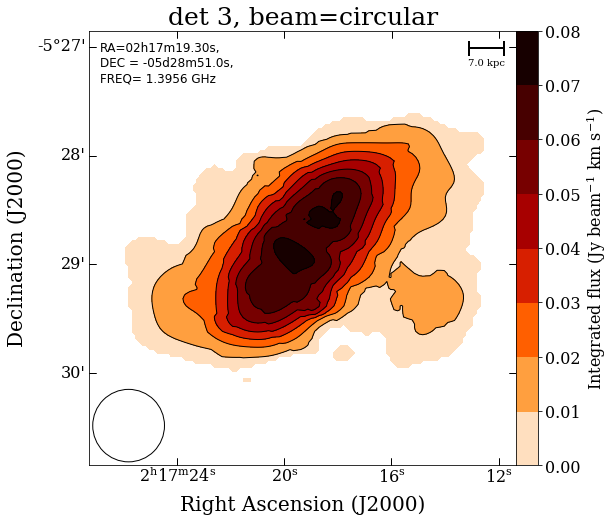

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


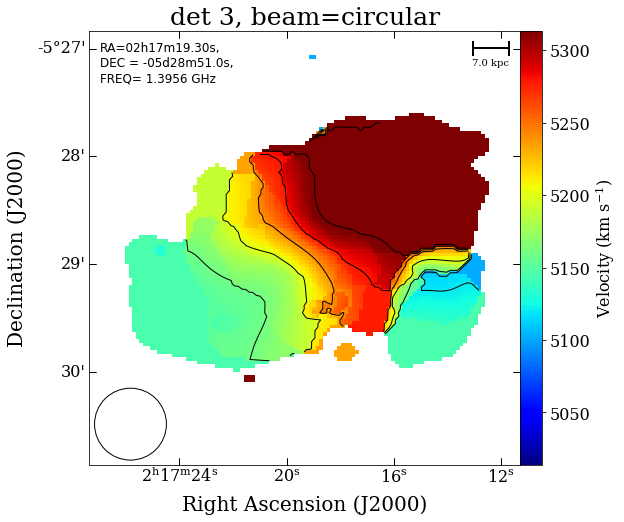

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


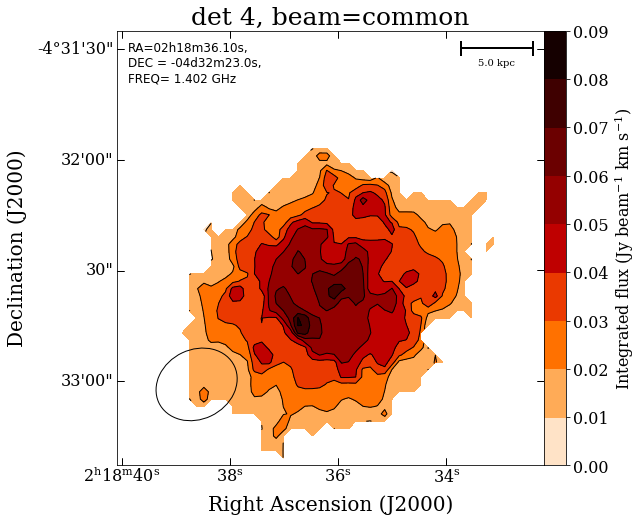

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


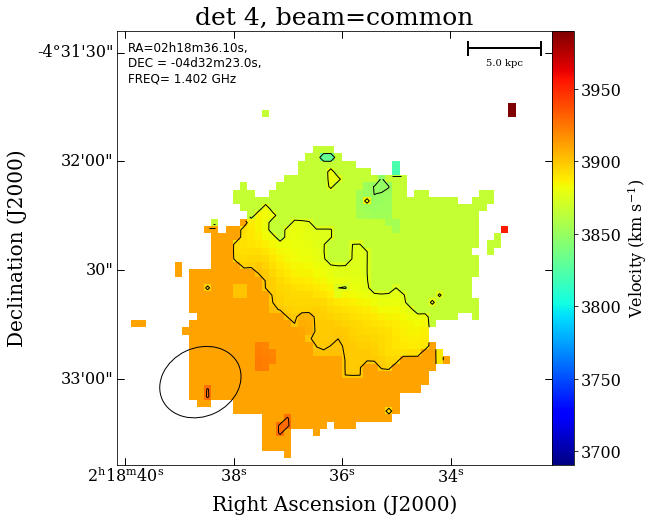

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


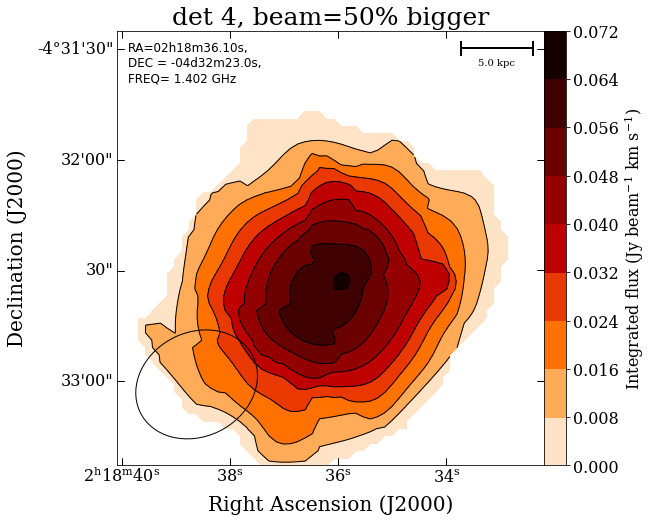

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


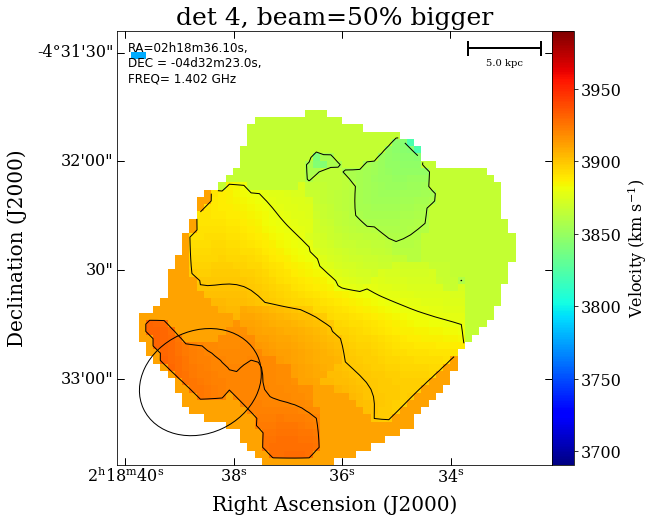

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


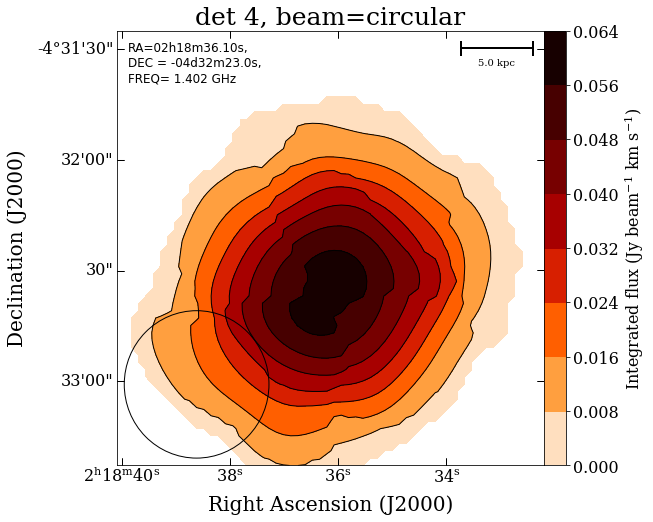

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


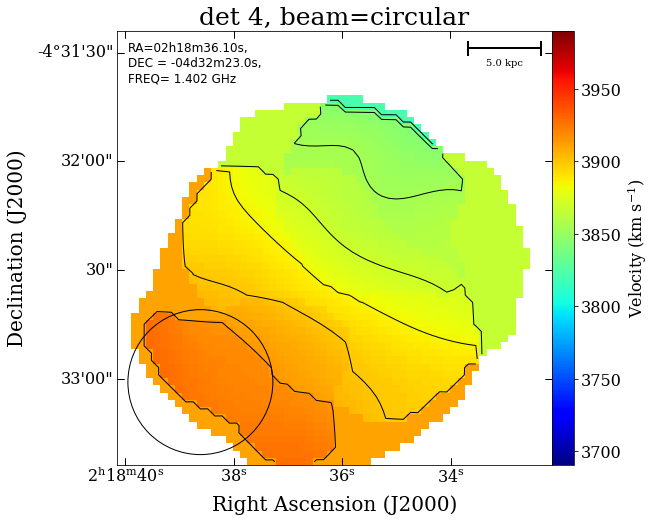

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


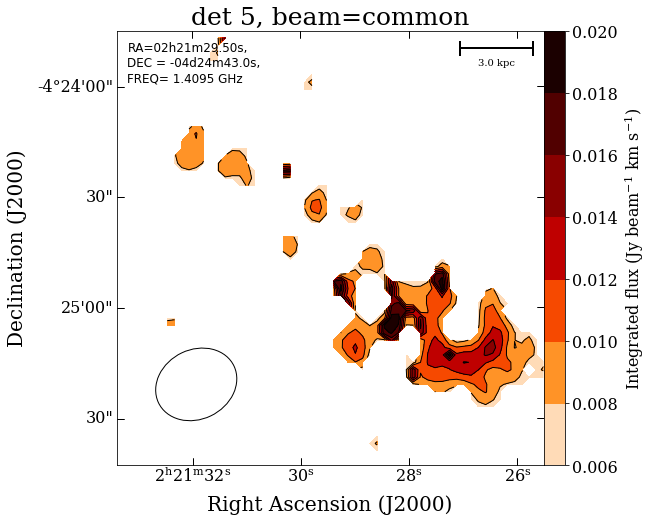

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


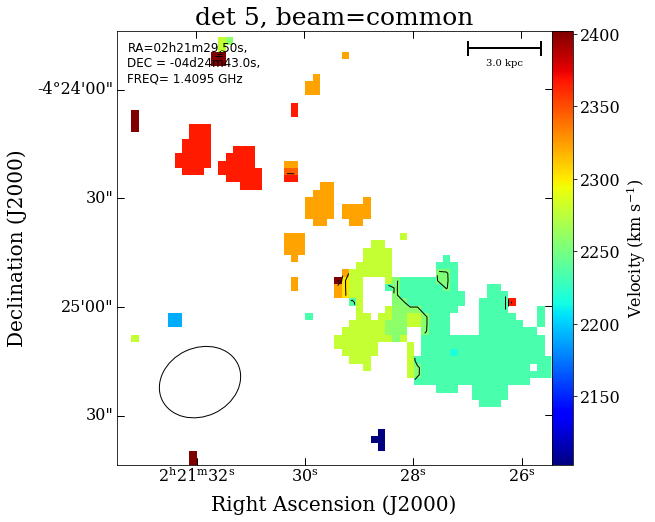

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


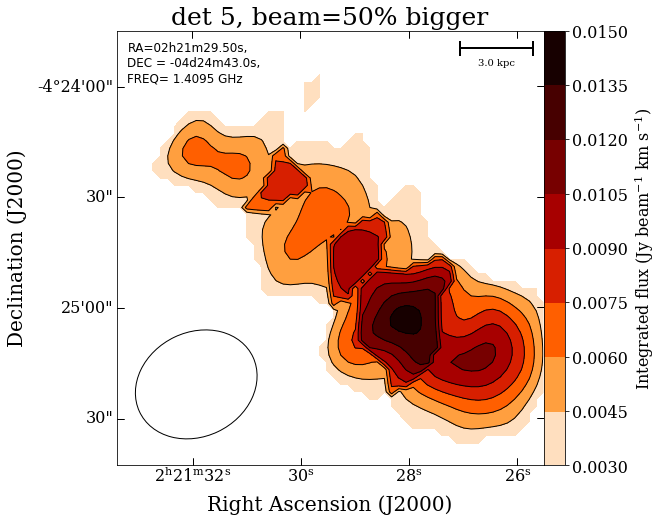

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


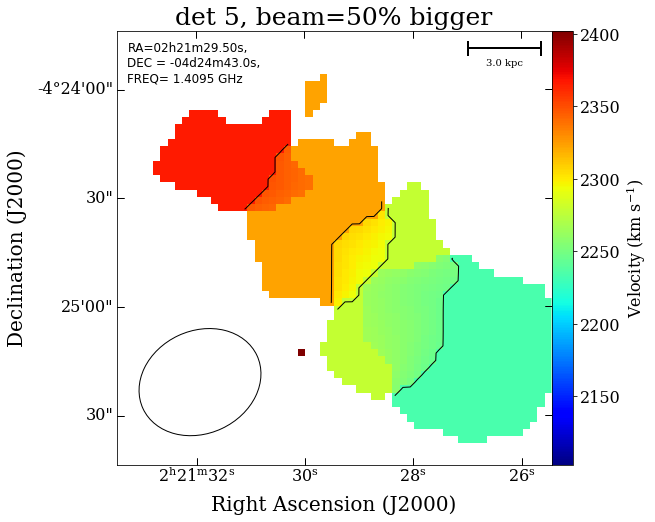

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


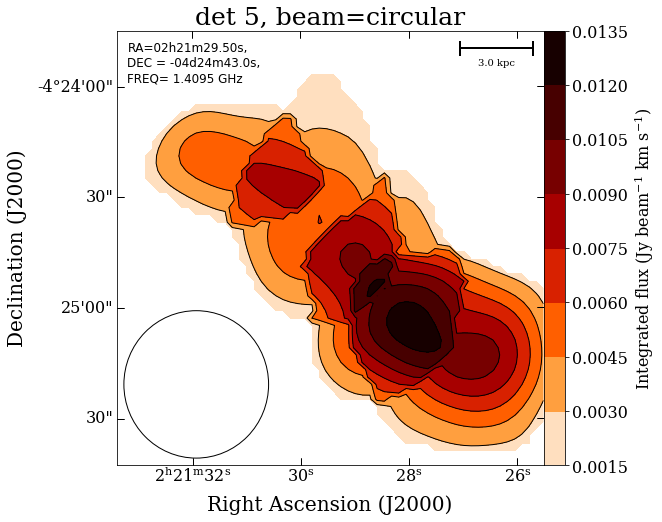

/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


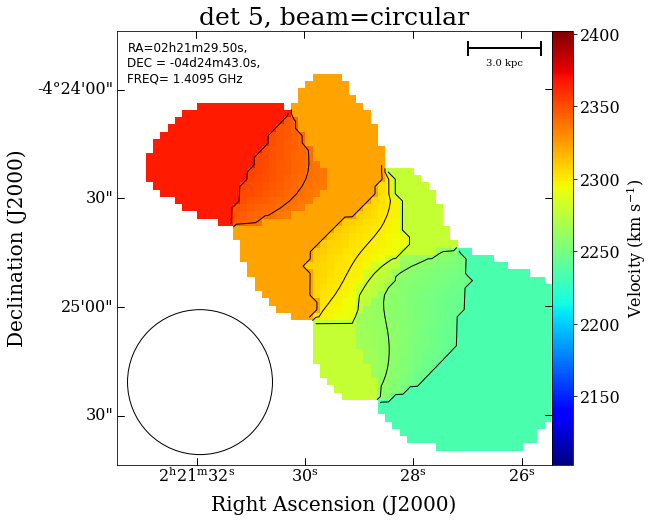

In [9]:
#Moment maps
from matplotlib.offsetbox import AnchoredText

beam_str = ['common','50% bigger','circular']
beam = [common_beam,beam50,circular_beam]
rms = [mean_rms_common,mean_rms_beam50,mean_rms_circular]
subcube = [vel_common,vel_beam50,vel_circular]

import os
import shutil

if not os.path.exists(dirName):
    os.makedirs(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists and will be overwritten")
    shutil.rmtree(dirName)
    os.makedirs(dirName)
    
for i in range(len(detections)):
    if not os.path.exists(dirName+'/detection_'+str(i+1)):
        os.makedirs(dirName+'/detection_'+str(i+1))
    else:
        shutil.rmtree(dirName+'/detection_'+str(i+1))
        os.makedirs(dirName+'/detection_'+str(i+1))
    for j in range(len(beam)):
        fig = pl.figure(figsize=(9, 8))
        ax = fig.add_subplot(1,1,1,projection=subcube[j][i][1].wcs)
        anchored_text = AnchoredText('RA='+detections[i]['ra']+',\n'+'DEC = '+detections[i]['dec']+',\nFREQ= '+str(detections[i]['freq'])+' GHz',
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
        ax.add_artist(anchored_text)
        moment_0(subcube[j][i],rms[j][i],beam[j],scale[i], sigma=sigma, title='det '+str(i+1)+', beam='+beam_str[j])
        plt.savefig(dirName+'/detection_'+str(i+1)+'/mom0_det_'+str(i+1)+'_'+beam_str[j]+'_beam',overwrite=True, bbox_inches = "tight")
        fig = pl.figure(figsize=(10, 8))
        ax = fig.add_subplot(1,1,1,projection=subcube[j][i][1].wcs)
        anchored_text = AnchoredText('RA='+detections[i]['ra']+',\n'+'DEC = '+detections[i]['dec']+',\nFREQ= '+str(detections[i]['freq'])+' GHz', 
                                     loc=2, borderpad=0.5,frameon=False, 
                             prop={'family': 'Sans serif', 'size': 12, 'fontweight': 'normal'})
        ax.add_artist(anchored_text)
        moment_1(subcube[j][i],rms[j][i],beam[j],scale[i], sigma=sigma, title='det '+str(i+1)+', beam='+beam_str[j])
        plt.savefig(dirName+'/detection_'+str(i+1)+'/mom1_det_'+str(i+1)+'_'+beam_str[j]+'_beam',overwrite=True, bbox_inches = "tight")